In [1]:
import spacy


from pathlib import Path


from spacy.tokens import Doc
from spacy.vocab import Vocab


import numpy as np

from collections import Counter

from tqdm import tqdm

In [2]:

root = Path('../data/sections')

# Data

In [3]:
def loader():
    for path in tqdm(sorted(root.glob('*.spacy'))):
        doc = Doc(Vocab()).from_disk(path)
        yield doc

# TF-IDF 

In [4]:
import re

In [5]:
fix_whitespace = re.compile('\s+')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True)

context_size = 10
corpus = []
i2ent = []
ent2i = {}
i = 0
for doc in loader():
    for ent in doc.ents:
        before = doc[ent.start-context_size:ent.start]

        after = doc[ent.end:ent.end+context_size]
        ent2i.setdefault(ent.text, [])
        ent2i[ent.text].append(i)
        i2ent.append(ent.text)
        corpus.append(before.text + ' ' + after.text)
        i+=1
        # after_text = fix_whitespace.sub(' ', after.text)
        # before_text = fix_whitespace.sub(' ', before.text)
        # print(before_text,'**', fix_whitespace.sub(' ',ent.text),'**', after_text)

In [11]:
context_size = 10
corpus = []
ent_contexts = {}
i = 0
for doc in loader():
    for ent in doc.ents:
        before = doc[ent.start-context_size:ent.start]

        after = doc[ent.end:ent.end+context_size]
        ent_contexts.setdefault(ent.text, [])
        ent_contexts[ent.text].append(before.text + ' ' + after.text)
    #break

100%|██████████| 107/107 [00:20<00:00,  5.22it/s]


In [12]:
ents_texts, corpus = [], []
for ent_text, ent_context in ent_contexts.items():
    ents_texts.append(ent_text)
    corpus.append(' '.join(ent_context))

In [13]:
len(ent_contexts), len(ents_texts), len(corpus)

(8523, 8523, 8523)

In [20]:
ents_texts[1], len(ent_contexts[ents_texts[1]]), corpus[1]

('Swann',
 1030,
 " \n1. Du Côté de Chez Swann\nPremière \xa0:\n«\xa0Je reconnais la voix de .\xa0» On ne le reconnaissait en effet qu’ était accouru auprès de lui dans la propriété que les \npossédaient aux environs de Combray, et avait réussi \npeu à la fois, comme le pauvre père \xa0», était devenu une des phrases\nfavorites différentes. Il m’aurait paru que ce père de était un monstre, si mon\ngrand-père que je incognito\nque lui faisait chez nous ce nom de , ils hébergeaient –\xa0avec la\nparfaite innocence nous étions de cette brillante vie mondaine\nque menait tenait évidemment en partie à la réserve et à la l’on\navait voulu à toute force appliquer à un coefficient social qui lui fût\npersonnel, entre cause du rôle ridicule que s’y\ndonnait toujours ou de l’esprit qu’il mettait à les conter \nfaire remarquer aux étrangers, quand on parlait de , qu’il aurait pu, s’il\navait dire\xa0: «\xa0Eh bien\xa0! Monsieur , vous habitez\ntoujours près de l’Entrepôt des si l’on avait dit à m

In [21]:
doc_term = tfidf.fit_transform(corpus)

In [24]:
ent_terms = doc_term

In [22]:
doc_term.shape

(8523, 23253)

In [23]:
terms = np.array(list(tfidf.vocabulary_.keys()))
indices = np.array(list(tfidf.vocabulary_.values()))
inverse_vocabulary = terms[np.argsort(indices)]

ent_term = {}

ent_texts, ent_terms = [], []
for ent_text, ent_i in ent2i.items():
    ent_terms.append(doc_term[np.array(ent_i)].mean(axis=0).A1)
    ent_texts.append(ent_text)

In [39]:
contexts = []
for ent_term in ent_terms:
    context = inverse_vocabulary[np.argsort(ent_term.A[0])[-5:]]
    contexts.append(', '.join(context))

In [40]:
contexts[1]

'amour, verdurin, phrase, forcheville, odette'

# Word2Vec 

In [35]:
ents_counter = Counter()
ents_vectors = dict()

for path in tqdm(sorted(root.glob('*.spacy'))):
    doc = Doc(Vocab()).from_disk(path)
    for ent in doc.ents:
        ents_counter[ent.text]+=1
        if ent.text not in ents_vectors:
            ents_vectors[ent.text] = ent.vector

100%|██████████| 108/108 [00:16<00:00,  6.55it/s]


In [36]:
ents_counter.most_common(100)

[('Albertine', 1890),
 ('Swann', 1030),
 ('M.\xa0de\xa0Charlus', 831),
 ('Balbec', 661),
 ('Françoise', 644),
 ('Saint-Loup', 639),
 ('Gilberte', 570),
 ('Odette', 547),
 ('Guermantes', 521),
 ('Paris', 501),
 ('Morel', 417),
 ('Mme\xa0Verdurin', 401),
 ('Bloch', 385),
 ('Mme\xa0de\xa0Guermantes', 367),
 ('Combray', 361),
 ('Robert', 301),
 ('Mme\xa0de\xa0Villeparisis', 297),
 ('Andrée', 296),
 ('Bergotte', 283),
 ('Mme\xa0Swann', 271),
 ('Brichot', 269),
 ('Verdurin', 268),
 ('Elstir', 233),
 ('Cottard', 208),
 ('Ah\xa0!', 206),
 ('Jupien', 196),
 ('Mme\xa0', 188),
 ('M.\xa0de\xa0Norpois', 173),
 ('Oriane', 146),
 ('Rachel', 135),
 ('Venise', 133),
 ('M.\xa0Verdurin', 127),
 ('M.\xa0de\xa0Guermantes', 120),
 ('Legrandin', 117),
 ('Berma', 114),
 ('duchesse de Guermantes', 110),
 ('Vinteuil', 109),
 ('Monsieur', 103),
 ('Mlle\xa0Vinteuil', 103),
 ('Charlus', 100),
 ('Mme\xa0de\xa0Cambremer', 96),
 ('Aimé', 94),
 ('princesse de Parme', 93),
 ('Cambremer', 93),
 ('Forcheville', 92),
 ('D

In [37]:
len(ents_vectors)

8528

In [38]:
list(ents_counter) == list(ents_vectors)

True

In [39]:
list(ents_counter)[:100],list(ents_vectors)[:100]

(['RECHERCHE DU TEMPS',
  'Marcel Proust',
  'Web',
  'Marcel Proust\nmarcel-proust.com\n\xa0\n\n',
  'général A',
  'Versailles',
  'Texte',
  'Côté de Chez',
  'Swann',
  'Swann\nPremière',
  'Combray\nI.\nLongtemps',
  'François\xa0',
  'Charles Quint',
  '–\xa0date pour moi d’une ère nouvelle\xa0',
  'Ève',
  'Adam',
  'Si',
  '–\xa0mon corps',
  'Bohême',
  'Sienne',
  'Combray',
  'grands-parents',
  'Mme\xa0de\xa0Saint-Loup',
  'Dieu\xa0!',
  'Tansonville',
  'Débats roses',
  'hirondelle\nde mer',
  'lune',
  'Louis\xa0XVI',
  'le bon ange',
  'Balbec',
  'Paris',
  'Doncières',
  'Venise',
  'Golo',
  'Geneviève de Brabant',
  'Geneviève',
  'Brabant',
  'porte de ma\nchambre',
  'Barbe-Bleue',
  'Françoise',
  '–\xa0à\nun des moments où la révolution',
  'cognac\xa0!',
  'Roussainville-le-Pin',
  'volupté',
  'M.\xa0Swann',
  'grand\nmarronnier',
  'M.\xa0Swann\xa0',
  'Bressant',
  'homme\nexcellent',
  'chambre\nmortuaire',
  'soleil',
  'Ah\xa0!',
  'Amédée\xa0!',
  'incog

In [45]:
embeddings = np.stack(list(ents_vectors.values()))

In [46]:
embeddings.shape

(8528, 96)

# UMAP

In [41]:
import umap

/home/lerner/anaconda3/envs/meerqat/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
model = umap.UMAP(metric='cosine')

In [43]:
embeddings = ent_terms

In [44]:
model.fit(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [45]:
reduced_embeddings = model.transform(embeddings)

In [46]:
reduced_embeddings.shape

(8523, 2)

In [47]:
import matplotlib.pyplot as plt

In [49]:
#sizes = np.array(list(ents_counter.values()))
sizes = np.array([len(ent_contexts[ent_text]) for ent_text in ents_texts])

In [50]:
sizes.shape

(8523,)

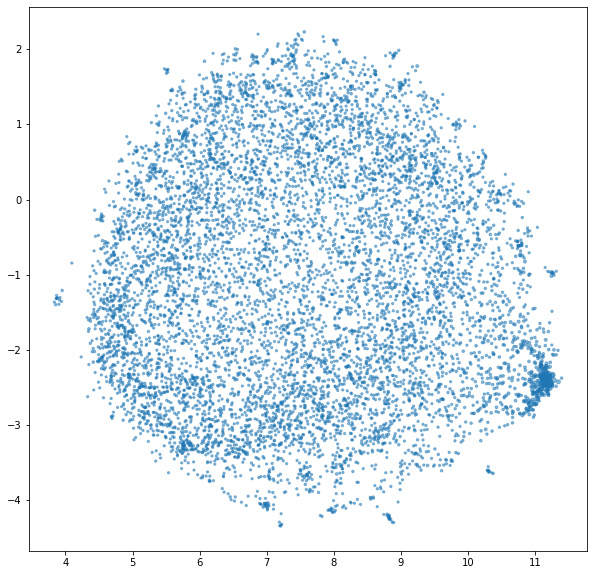

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(reduced_embeddings[:,0],reduced_embeddings[:,1],s=np.sqrt(sizes)+4,alpha=0.5)

In [52]:
import pandas as pd

In [54]:
df = pd.DataFrame(dict(text = ents_texts, x = reduced_embeddings[:,0], y=reduced_embeddings[:,1], size=np.sqrt(sizes)+4,context=contexts))

In [55]:
df

,text,x,y,size,context
0,Côté de Chez,8.852188,-1.169066,5.414214,"combray, du, chez, côté, swann"
1,Swann,11.200426,-2.449027,36.093613,"amour, verdurin, phrase, forcheville, odette"
2,Swann\nPremière,8.844629,-1.290819,5.000000,"côté, partie, longtemps, combray, chez"
3,Combray\nI.\nLongtemps,8.800426,-1.238438,5.000000,"partie, première, bonne, parfois, couché"
4,François,8.098380,-2.781272,5.000000,"ier, quatuor, survivait, rivalité, quint"
...,...,...,...,...,...
8518,Les Mille et Une Nuits\npeut-être,8.714006,-0.479439,5.000000,"tout, quand, sans, autre, doute"
8519,« Suis-je,7.209217,-0.833200,5.000000,"mais, temps, état, encore, maladie"
8520,François le Champi !,8.550644,-0.376939,5.000000,"mère, alors, apercevant, évoquée, soirée"
8521,sonnette\n,7.852515,-2.598706,5.000000,"annonçait, frais, intarissable, ferrugineux, c..."


In [56]:
from bokeh.plotting import figure, output_file, save
from bokeh.models import ColumnDataSource, HoverTool

In [57]:
source = ColumnDataSource(df)

In [58]:
plot_figure = figure(
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <p>@text: @context</p>
    </div>
</div>
"""))
plot_figure.circle(
    'x',
    'y',
    source=source,
    line_alpha=0.3,
    fill_alpha=0.3,
    size='size'
)

GlyphRenderer(id='1033', ...)

In [59]:
output_file('../data/tfidif2_ents_umap_with_ctx.html')

In [60]:
save(plot_figure)

'/home/lerner/Documents/proust/data/tfidif2_ents_umap_with_ctx.html'